In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import pandas as pd
from datetime import datetime
import lightgbm as lgb
from dotenv import load_dotenv
load_dotenv() 
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.config import TRANSFORMED_DATA_DIR
from src.data_utils import split_time_series_data
from src.experiment_utils import set_mlflow_tracking, log_model_to_mlflow

In [2]:
# Function to check stationarity
def check_stationarity(time_series):
    result = adfuller(time_series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is NOT stationary. Consider differencing.")

# Function to fit ARMA model
def fit_arma_model(train_data, ar_order, ma_order):
    model = ARIMA(train_data, order=(ar_order, 0, ma_order))  # ARMA is a special case of ARIMA with d=0
    results = model.fit()
    print(results.summary())
    return results

# Function to evaluate predictions
def evaluate_predictions(test_data, predictions):
    mae = mean_absolute_error(test_data, predictions)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    return mae



In [3]:
def split_time_series_data_percentage(
    df: pd.DataFrame,
    target_column: str,
) -> tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Splits a time series DataFrame into training, validation, and testing sets (70%, 20%, 10%).

    Args:
        df (pd.DataFrame): The input DataFrame containing the time series data.
        target_column (str): The name of the target column to separate from the features.

    Returns:
        Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
            - X_train (pd.DataFrame): Training features (70% of data).
            - y_train (pd.Series): Training target values.
            - X_val (pd.DataFrame): Validation features (20% of data).
            - y_val (pd.Series): Validation target values.
            - X_test (pd.DataFrame): Testing features (10% of data).
            - y_test (pd.Series): Testing target values.
    """
    # Sort the DataFrame by date
    df_sorted = df.sort_values("pickup_hour")

    # Calculate the split indices
    train_end = int(len(df) * 0.5)
    val_end = int(len(df) * 0.8)

    # Split the data into training, validation, and testing sets
    train_data = df_sorted[:train_end].reset_index(drop=True)
    val_data = df_sorted[train_end:val_end].reset_index(drop=True)
    test_data = df_sorted[val_end:].reset_index(drop=True)

    # Separate features (X) and target (y) for all three sets
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    X_val = val_data.drop(columns=[target_column])
    y_val = val_data[target_column]
    X_test = test_data.drop(columns=[target_column])
    y_test = test_data[target_column]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [4]:
df = pd.read_parquet(TRANSFORMED_DATA_DIR / "tabular_data.parquet")
df.head(5)
df.shape
X_train, y_train, X_val, y_val, X_test, y_test = split_time_series_data_percentage(df, target_column="target")

Testing ARMA(0,0)...
ARMA(0,0) - Validation MAE: 17.42
Testing ARMA(0,1)...
ARMA(0,1) - Validation MAE: 17.42
Testing ARMA(0,2)...
ARMA(0,2) - Validation MAE: 17.42
Testing ARMA(0,3)...
ARMA(0,3) - Validation MAE: 17.42
Testing ARMA(0,4)...
ARMA(0,4) - Validation MAE: 17.42
Testing ARMA(0,5)...
ARMA(0,5) - Validation MAE: 17.42
Testing ARMA(1,0)...
ARMA(1,0) - Validation MAE: 17.42
Testing ARMA(1,1)...
ARMA(1,1) - Validation MAE: 17.50
Testing ARMA(1,2)...
ARMA(1,2) - Validation MAE: 17.48
Testing ARMA(1,3)...


c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(1,3) - Validation MAE: 17.47
Testing ARMA(1,4)...
ARMA(1,4) - Validation MAE: 17.47
Testing ARMA(1,5)...
ARMA(1,5) - Validation MAE: 17.47
Testing ARMA(2,0)...
ARMA(2,0) - Validation MAE: 17.42
Testing ARMA(2,1)...
ARMA(2,1) - Validation MAE: 17.47
Testing ARMA(2,2)...
ARMA(2,2) - Validation MAE: 17.53
Testing ARMA(2,3)...


c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(2,3) - Validation MAE: 17.63
Testing ARMA(2,4)...
ARMA(2,4) - Validation MAE: 17.46
Testing ARMA(2,5)...


c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARMA(2,5) - Validation MAE: 17.46
Testing ARMA(3,0)...
ARMA(3,0) - Validation MAE: 17.42
Testing ARMA(3,1)...


c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(3,1) - Validation MAE: 17.46
Testing ARMA(3,2)...


c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(3,2) - Validation MAE: 17.63
Testing ARMA(3,3)...


c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(3,3) - Validation MAE: 17.47
Testing ARMA(3,4)...


c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARMA(3,4) - Validation MAE: 17.47
Testing ARMA(3,5)...


c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(3,5) - Validation MAE: 17.48
Testing ARMA(4,0)...
ARMA(4,0) - Validation MAE: 17.42
Testing ARMA(4,1)...


c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(4,1) - Validation MAE: 17.46
Testing ARMA(4,2)...


c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(4,2) - Validation MAE: 17.46
Testing ARMA(4,3)...


c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(4,3) - Validation MAE: 17.46
Testing ARMA(4,4)...


c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARMA(4,4) - Validation MAE: 17.47
Testing ARMA(4,5)...


c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(4,5) - Validation MAE: 17.47
Testing ARMA(5,0)...
ARMA(5,0) - Validation MAE: 17.42
Testing ARMA(5,1)...


c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(5,1) - Validation MAE: 17.46
Testing ARMA(5,2)...


c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(5,2) - Validation MAE: 17.46
Testing ARMA(5,3)...


c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(5,3) - Validation MAE: 17.47
Testing ARMA(5,4)...


c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARMA(5,4) - Validation MAE: 17.46
Testing ARMA(5,5)...


c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(5,5) - Validation MAE: 17.47
Best ARMA(0,0) - Validation MAE: 17.42
Test Set MAE: 18.71


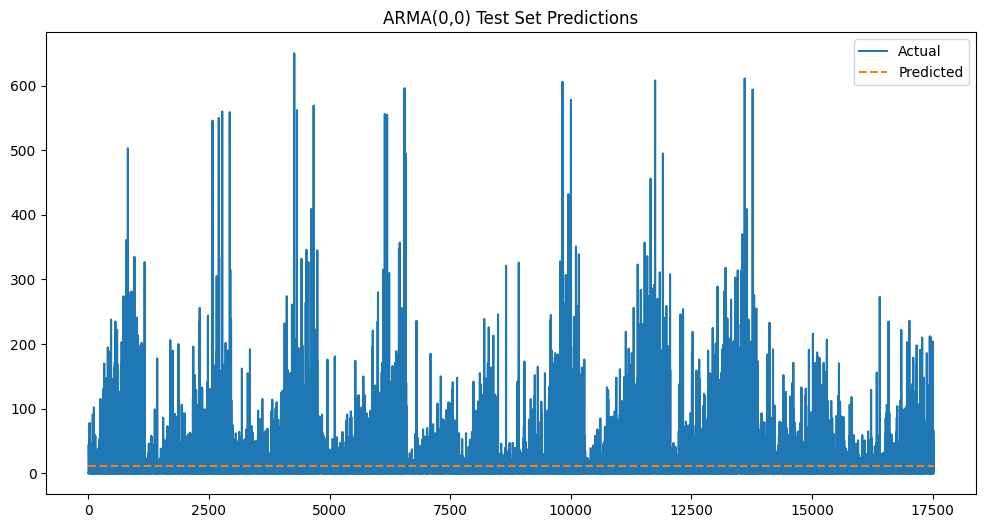

In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Function to fit ARMA model and calculate evaluation metrics
def fit_arma_model(train_data, val_data, p, q):
    try:
        # Fit ARMA model (d=0 for ARMA)
        model = ARIMA(train_data, order=(p, 0, q))
        results = model.fit()
        
        # Forecast on validation set
        forecast_val = results.forecast(steps=len(val_data))
        
        # Calculate MAE
        mae = mean_absolute_error(val_data.values, forecast_val)
        print(f"ARMA({p},{q}) - Validation MAE: {mae:.2f}")
        
        return results, mae
    except Exception as e:
        print(f"Error fitting ARMA({p},{q}): {e}")
        return None, float("inf")

# Function to perform grid search for optimal p and q values
def grid_search_arma(train_data, val_data, max_p=5, max_q=5):
    best_p = None
    best_q = None
    best_mae = float("inf")
    best_model = None
    
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            print(f"Testing ARMA({p},{q})...")
            model, mae = fit_arma_model(train_data, val_data, p, q)
            if mae < best_mae:
                best_p, best_q = p, q
                best_mae = mae
                best_model = model
    
    print(f"Best ARMA({best_p},{best_q}) - Validation MAE: {best_mae:.2f}")
    return best_model, best_p, best_q

# Example usage with your data splits
X_train, y_train, X_val, y_val, X_test, y_test = split_time_series_data_percentage(df, target_column="target")

# Perform grid search to find optimal p and q values
max_p = 5  # Maximum AR order to test
max_q = 5  # Maximum MA order to test
best_model, best_p, best_q = grid_search_arma(y_train, y_val, max_p=max_p, max_q=max_q)

if best_model is not None:
    # Forecast on the test set using the best model
    forecast_test = best_model.forecast(steps=len(y_test))

    # Evaluate performance on the test set
    test_mae = mean_absolute_error(y_test.values, forecast_test)
    print(f"Test Set MAE: {test_mae:.2f}")

    # Plot actual vs predicted values for the test set
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label="Actual")
    plt.plot(y_test.index, forecast_test.values, label="Predicted", linestyle="--")
    plt.title(f"ARMA({best_p},{best_q}) Test Set Predictions")
    plt.legend()
    plt.show()
else:
    print("No valid ARMA model found during grid search.")
